In [2]:
import Pkg; Pkg.add("YAML")

    Updating registry at `~/.julia/registries/General`
   Resolving package versions...
    Updating `~/.julia/environments/v1.6/Project.toml`
  [ddb6d928] + YAML v0.4.8
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [3]:
using ReactionMechanismSimulator
using PyPlot
using DifferentialEquations
using Sundials
using YAML
using LinearAlgebra

## just analyze the baseline model for now

In [4]:
file_dir = "/Users/blais.ch/Documents/_01_code/05_Project_repos_Github/meOH_repos/uncertainty_analysis/rmg_gua/baseline/rms/chem53.rms"
# file_dir = "/work/westgroup/ChrisB/_01_MeOH_repos/meOH-synthesis/base/rms/chem27.rms"
# file_dir = "./modified_rms.rms"
phaseDict = readinput(file_dir); #load mechanism dictionary

┌ Warning: failed to generate StokesDiffusivity model for species X
└ @ ReactionMechanismSimulator ~/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species H*
└ @ ReactionMechanismSimulator ~/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species O*
└ @ ReactionMechanismSimulator ~/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species OH*
└ @ ReactionMechanismSimulator ~/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species H2O*
└ @ ReactionMechanismSimulator ~/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species CO*
└ @ ReactionMechanismSimulator ~/Docum

### load in yaml file with experimental inputs

In [5]:
expt_condts = "/Users/blais.ch/Documents/_01_code/05_Project_repos_Github/meOH_repos/uncertainty_analysis/rmg_gua/gua_cantera/all_experiments_reorg_sbr.yaml"
data = YAML.load_file(expt_condts);

In [6]:
# # find condition where there is only CO
# for (index, condition) in enumerate(data)
#     if condition["species"]["CO2"] != 0 
#         println(index)
#     end
# end

In [7]:
conditions = data[2]

# convert volume flow to molar flow
conditions["volume_flowrate"]

FC_temp = 293.15
conditions["molar_flow"] = conditions["volume_flowrate"] * 1.01325e5 / (8.3145 * FC_temp) 

0.0006214865996264639

In [8]:
conditions

Dict{Any, Any} with 12 entries:
  "output"          => Dict{Any, Any}("CH3OH"=>0.00112229, "H2O"=>0.00116906)
  "experiment_type" => "sbr"
  "temperature"     => 483.5
  "use_for_opt"     => false
  "pressure"        => 1.5e6
  "species"         => Dict{Any, Any}("CO"=>0.065, "CO2"=>0.261, "H2"=>0.674)
  "expt_name"       => "graaf_1988"
  "molar_flow"      => 0.000621487
  "volume"          => 0.000134696
  "catalyst_area"   => 44.4242
  "volume_flowrate" => 1.495e-5
  "run_num"         => 2.0

In [9]:
conditions["volume_flowrate"]

1.495e-5

In [10]:
conditions["molar_flow"] 

0.0006214865996264639

In [11]:
gasspcs = phaseDict["gas"]["Species"]; # mechanism dictionaries index:  phaseDict[phasename]["Species" or "Reactions"]
gasrxns = phaseDict["gas"]["Reactions"];
surfacespcs = phaseDict["surface"]["Species"];
surfacerxns = phaseDict["surface"]["Reactions"];
interfacerxns = phaseDict[Set(["gas","surface"])]["Reactions"];

In [12]:
ig = IdealGas(gasspcs,gasrxns;name="gas"); #Define the phase (how species thermodynamic and kinetic properties calculated)
cat = IdealSurface(surfacespcs,surfacerxns,2.943e-5;name="surface");

In [13]:
initialcondsgas = Dict([
        "T"=>conditions["temperature"],
        "P"=>conditions["pressure"],
        "CO"=>conditions["species"]["CO"],
        "CO2"=>conditions["species"]["CO2"],
        "H2"=>conditions["species"]["H2"]
        ]); #Set simulation Initial Temp and Pressure
# Define the domain (encodes how system thermodynamic properties calculated)
domaingas,y0gas,pgas = ConstantTPDomain(phase=ig,initialconds=initialcondsgas,sensitivity=true); 

In [14]:
V = conditions["volume"]
A = conditions["catalyst_area"]
initialconds = Dict([
        "T"=>conditions["temperature"],
        "A"=>conditions["catalyst_area"],
        "X"=>cat.sitedensity*A]); #Set simulation Initial Temp and Pressure
# Define the domain (encodes how system thermodynamic properties calculated)
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=cat,initialconds=initialconds,sensitivity=true);

## make reactor, inlet and outlet
- makes an anonymous function x->42, is that velocity in? need to check if it is velocity or volume flowrate
- also, I think the ```phi``` refers to chemical potential, but I should check, I think constantTPhi is just const T for our case. 

In [15]:
initialcondsinlet = Dict([
        "T"=>conditions["temperature"],
        "P"=>conditions["pressure"],
        "CO"=>conditions["species"]["CO"],
        "CO2"=>conditions["species"]["CO2"],
        "H2"=>conditions["species"]["H2"]
        ]);

# construct reactor
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domaingas,domaincat,interfacerxns,initialcondsinlet["T"],A);

# make inlet and outlet
inletgas = Inlet(domaingas,initialcondsinlet,x->conditions["molar_flow"]);
outletgas = Outlet(domaingas,x->conditions["molar_flow"]);

lets break these apart one by one: 
### ```react,y0,p = Reactor(domains,(y0liq,y0gas),(0.0,tf),interfaces,(pcat,pgas,pinter));```
- react = reactor object, returned from Reactor() function call
- y0 = initial values of all mole fractions, plus last index is... Temperature? 
- p - phases? 

In [16]:
# Define domains and interfaces
domains = (domaingas,domaincat)
interfaces = [inter,inletgas,outletgas]

# create a reactor for the system
react,y0,p = Reactor(domains,(y0gas,y0cat),(0.0,100),interfaces,(pgas,pcat,pinter)); # Create the reactor object
sol = solve(react.ode,react.recommendedsolver,abstol=1e-18,reltol=1e-6);

In [17]:
ssys = SystemSimulation(sol,domains,interfaces,p);

In [18]:
methods(SystemSimulation)

# 2 methods for type constructor:
[1] SystemSimulation(sol::B, sims::Q, interfaces::X, names::Vector{String}, species::Vector{Z}, reactions::Vector{Y}, p::Vector{Float64}) where {Q, B<:SciMLBase.AbstractODESolution, X, Y, Z} in ReactionMechanismSimulator at /Users/blais.ch/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/Simulation.jl:90
[2] SystemSimulation(sol, domains, interfaces, p) in ReactionMechanismSimulator at /Users/blais.ch/Documents/_01_code/RMG_env_1/ReactionMechanismSimulator.jl/src/Simulation.jl:113

In [57]:
molefractions(ssys.sims[1],100)

15-element Vector{Float64}:
 0.0
 0.0
 0.09905742759441083
 0.09697679817313605
 0.14358727564297674
 0.49150359644046265
 2.2910551345571785e-10
 4.757753471515335e-8
 1.4742487875090162e-6
 1.997278668443657e-12
 6.993838168207134e-8
 4.274028207176884e-8
 1.3891931123103535e-9
 0.0762209376675786
 0.0926523283561532

In [55]:
ssys.sims[2].domain

ConstantTAPhiDomain{IdealSurface{Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, ReactionMechanismSimulator.NASAvec{EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}(IdealSurface{Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, ReactionMechanismSimulator.NASAvec{EmptyThermoUncertainty}, Vector{Float64}}
  name: String "surface"
  species: Array{Species}((38,))
  reactions: Array{ElementaryReaction}((609,))
  stoichmatrix: SparseArrays.SparseMatrixCSC{Float64, Int64}
  Nrp: Array{Float64}((609,)) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  rxnarray: Array{Int64}((8, 609)) [1 1 … 16 16; 4 5 … 14 14; … ; 0 0 … 0 0; 0 0 … 0 0]
  veckinetics: Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}
  veckineticsinds: Arr

In [54]:
molefractions.(ssys.sims[2],100)

38-element Vector{Float64}:
 0.767129276742239
 0.008198898799897224
 3.734791707550318e-9
 6.929680137616964e-11
 0.015872734909555826
 0.0005167986734659645
 0.02412347732742996
 1.5479320841991656e-6
 3.577174694653341e-5
 1.0392339110033805e-6
 3.0860937060219714e-6
 7.200486604181666e-8
 4.224669638056029e-13
 ⋮
 2.3895166402488864e-9
 2.280418380463018e-11
 1.431758259675341e-14
 1.0657099242458914e-7
 4.8994457344663765e-12
 4.389268936875149e-13
 0.18405626706662628
 2.6867793957157298e-11
 1.4445184506612624e-16
 1.3623058558002733e-16
 1.8045233372697558e-9
 2.0729944811315468e-12

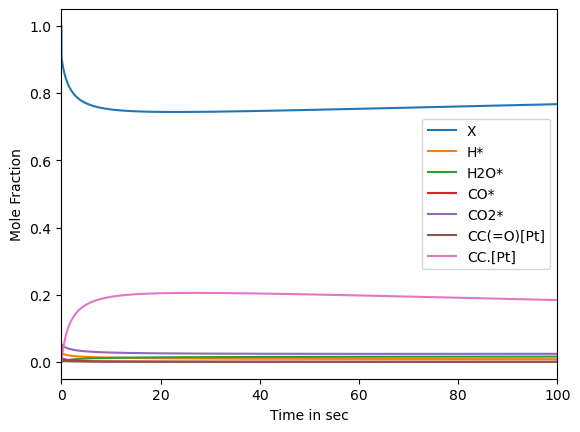

(0.0, 100.0)

In [49]:
plotmolefractions(ssys.sims[2],tol=0.001)
xlim(0.0,100)

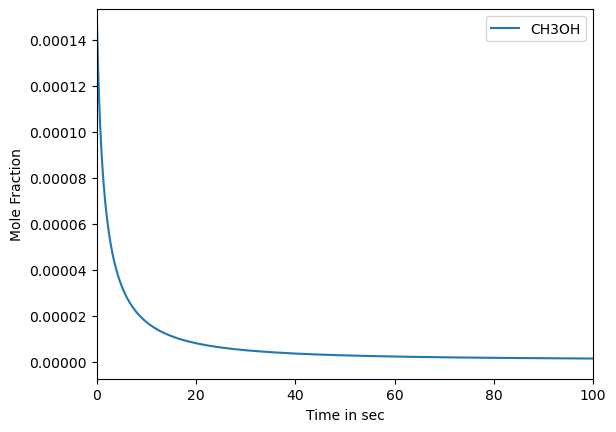

(0.0, 100.0)

In [ ]:
plotmolefractions(ssys.sims[1];exclude=["H2", "CO", "CO2", "H2O", "CCO","CH4", "CC" ],tol=0.000001)
xlim(0.0,100)

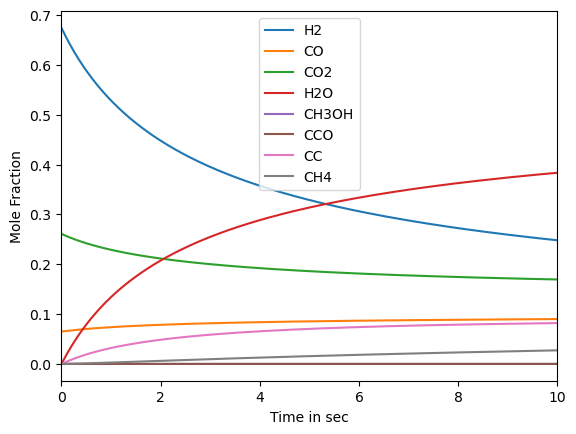

(0.0, 10.0)

In [ ]:
plotmolefractions(ssys.sims[1];exclude=["N2"],tol=0.000001)
xlim(0.0,10)

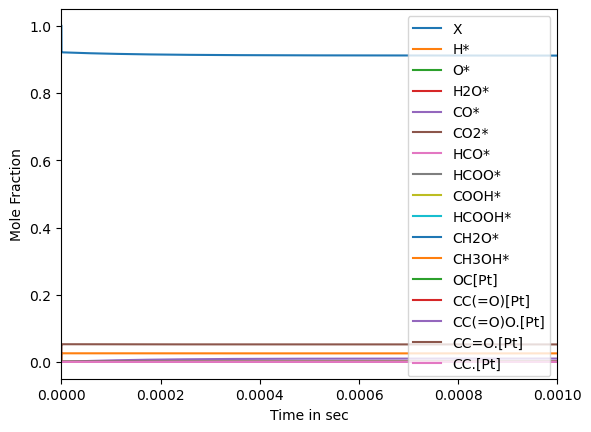

(0.0, 0.001)

In [ ]:
plotmolefractions(ssys.sims[2];exclude=["N2"],tol=0.000001)
xlim(0.0,0.001 )

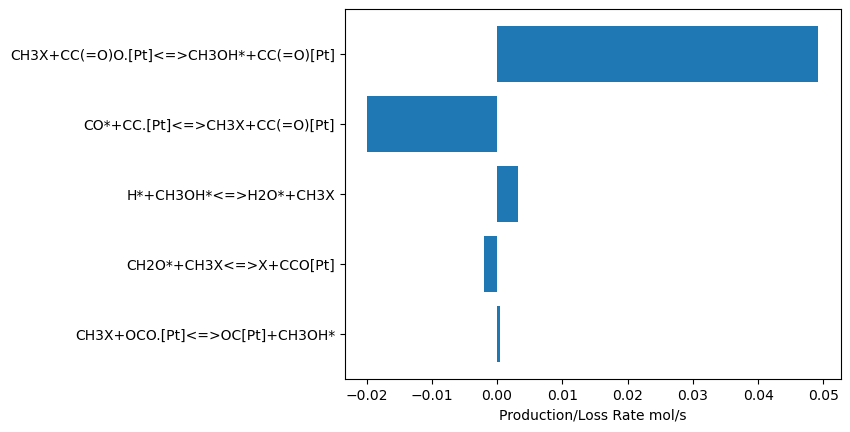

In [ ]:
plotrops(ssys.sims[2],"CH3X",1e-2)

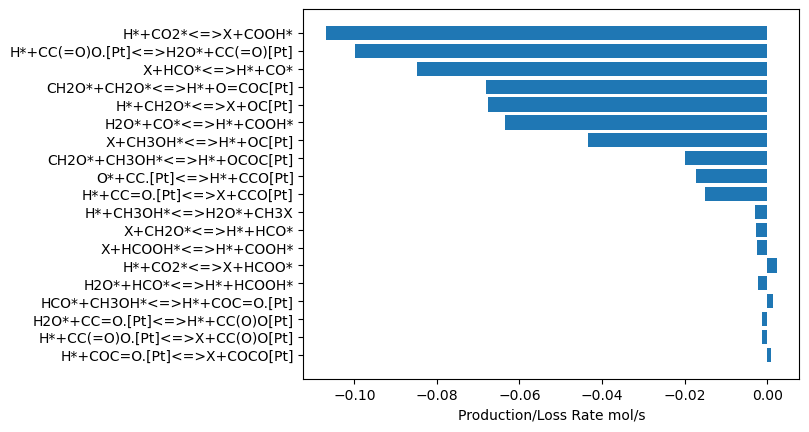

In [ ]:
plotrops(ssys.sims[2],"H*",0.1)

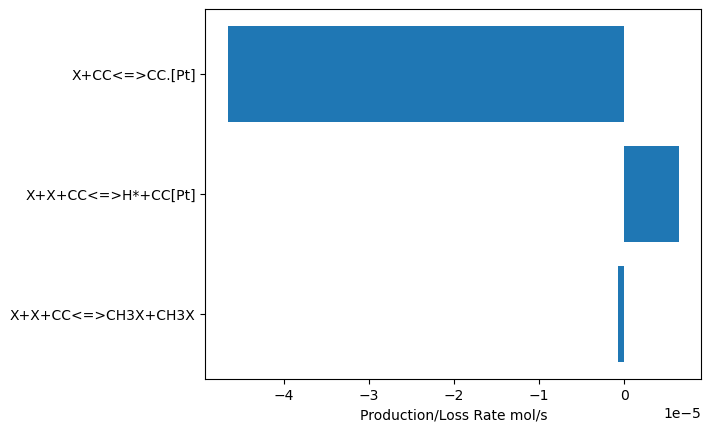

In [ ]:
plotrops(ssys,"CC",30)

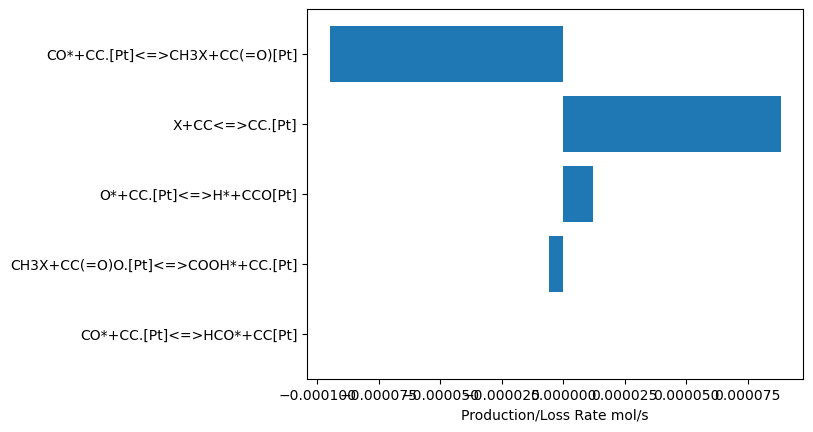

In [ ]:
plotrops(ssys,"CC.[Pt]",100)

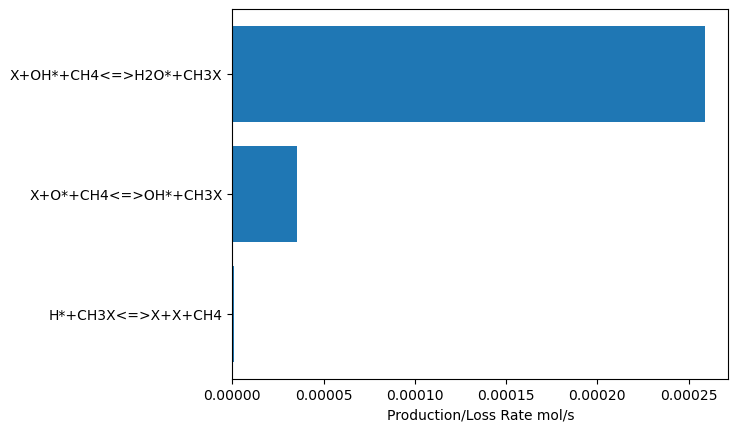

In [ ]:
plotrops(ssys,"CH4",100)

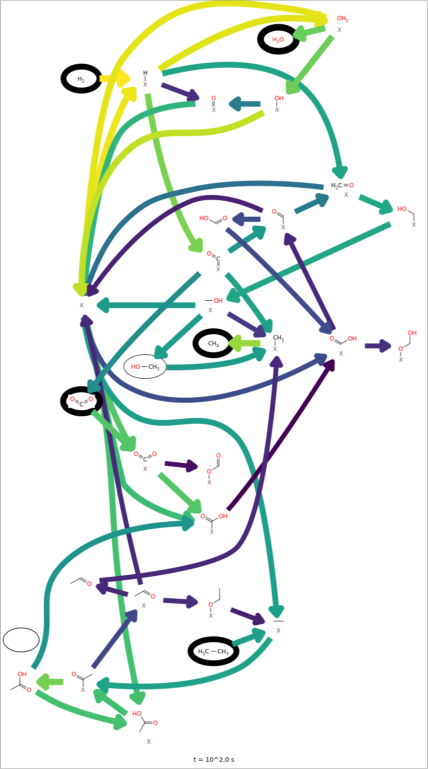

In [ ]:
getfluxdiagram(ssys,100)

## Stealing the "plotrxntransitorysensitivities" function so I can also grab the names

In [ ]:
function getrxntransitorysensitivities(bsol,name,t;dSdt=nothing,tau=nothing,tol=1e-3,N=0,rxntol=1e-6)
    if !(name in getfield.(bsol.species,:name))
        error("Species $name not in domain")
    elseif !isnothing(dSdt) && (sum(dim > 1 for dim in size(dSdt)) > 1 || maximum(size(dSdt)) != length(bsol.p))
        error("dSdt must be a vector of length number of parameters")
    end

    ind = findfirst(isequal(name),bsol.names)

    rts = rates(bsol,t)
    Rchar = norm(rts)
    Rthresh = rxntol*Rchar

    if dSdt === nothing
        if tau === nothing
            dSdt = transitorysensitivitiesfulltrapezoidal(bsol,t)[ind,length(bsol.names)+1:end]
        else
            dSdt = transitorysensitivitiesfulltrapezoidal(bsol,t,tau)[ind,length(bsol.names)+1:end]
        end
    else
        dSdt = dSdt[length(bsol.names)+1:end]
    end

    inds = reverse(sortperm(abs.(dSdt)))
    minval = 0.0
    dSdtmax = maximum(abs.(dSdt))
    maxthresh = dSdtmax*tol

    inds = [i for i in inds if abs(rts[i]) > Rthresh] #weak filter based on reaction flux

    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    inds = inds[1:N]
    mval = abs(dSdt[inds[1]])
    minval = mval*tol
    k = 1
    while k < length(inds) && abs(dSdt[inds[k]]) >= minval
        k += 1
    end
    inds = inds[1:k]
    xs = Array{Float64,1}(1:length(inds))
    sens = dSdt[inds]
    sens_reactions = bsol.reactions[inds]
#    sens_reactions = reverse(getrxnstr.(bsol.reactions[inds]))

    return sens_reactions, sens
end

getrxntransitorysensitivities (generic function with 1 method)

get most sensitive reactions. from rmg compare, see which of these is also showing up in comparison. 

get the ones that are important at 
- early times, CH3OH dominates 
- early times, CH4 dominates
- later timescales, CH4 dominates, close to SS

Reactions that consistently have high sensitivities will have a smaller number associated with them. 
this may be flawed because the highest sensitivity reactions will always have a 0 associated with them, but for now I think this is fine because I want those flagged anyway. 

also want to spit out the spiles for reactants and products

In [ ]:
sens_times = [1e-2, 3e-2, 100]
sens_rxn_dict = Dict()

for time in sens_times 
    sens_rxns, rxn_sens = getrxntransitorysensitivities(ssys, "CH3OH", time)
    counter = 0
    for (rxn, sens) in zip(sens_rxns, rxn_sens)
        if getrxnstr(rxn) in keys(sens_rxn_dict)
            old_sens = sens_rxn_dict[getrxnstr(rxn)][1]
            sens_rxn_dict[getrxnstr(rxn)][1] = counter*old_sens
        else
            reac_smiles = [reac.smiles for reac in rxn.reactants]
            prod_smiles = [prod.smiles for prod in rxn.products]
            sens_rxn_dict[getrxnstr(rxn)] = [counter, reac_smiles, prod_smiles]
        end
        counter +=1
    end
end

for time in sens_times 
    sens_rxns, rxn_sens = getrxntransitorysensitivities(ssys, "CC", time)
    counter = 0
    for (rxn, sens) in zip(sens_rxns, rxn_sens)
        if getrxnstr(rxn) in keys(sens_rxn_dict)
            old_sens = sens_rxn_dict[getrxnstr(rxn)][1]
            sens_rxn_dict[getrxnstr(rxn)][1] = counter*old_sens
        else
            reac_smiles = [reac.smiles for reac in rxn.reactants]
            prod_smiles = [prod.smiles for prod in rxn.products]
            sens_rxn_dict[getrxnstr(rxn)] = [counter, reac_smiles, prod_smiles]
        end
        counter +=1
    end
end

for time in sens_times 
    sens_rxns, rxn_sens = getrxntransitorysensitivities(ssys, "CH4", time)
    counter = 0
    for (rxn, sens) in zip(sens_rxns, rxn_sens)
        if getrxnstr(rxn) in keys(sens_rxn_dict)
            old_sens = sens_rxn_dict[getrxnstr(rxn)][1]
            sens_rxn_dict[getrxnstr(rxn)][1] = counter*old_sens
        else
            reac_smiles = [reac.smiles for reac in rxn.reactants]
            prod_smiles = [prod.smiles for prod in rxn.products]
            sens_rxn_dict[getrxnstr(rxn)] = [counter, reac_smiles, prod_smiles]
        end
        counter +=1
    end
end

Multiplies all of our reaction sensitivities by each other 

In [ ]:
sort(collect(sens_rxn_dict), by=x->x[2][1])

57-element Vector{Pair{Any, Any}}:
 "CC(=O)O.[Pt]+CC[Pt]<=>CC(=O)[Pt]+CCO.[Pt]" => Any[0, ["CC(=O)O.[Pt]", "CC[Pt]"], ["CC(=O)[Pt]", "CCO.[Pt]"]]
     "CH3X+CC(=O)O.[Pt]<=>CH3OH*+CC(=O)[Pt]" => Any[0, ["C[Pt]", "CC(=O)O.[Pt]"], ["CO.[Pt]", "CC(=O)[Pt]"]]
               "CO*+CH3OH*<=>OH*+CC(=O)[Pt]" => Any[0, ["O=C=[Pt]", "CO.[Pt]"], ["O[Pt]", "CC(=O)[Pt]"]]
             "CO*+CC.[Pt]<=>CH3X+CC(=O)[Pt]" => Any[0, ["O=C=[Pt]", "CC.[Pt]"], ["C[Pt]", "CC(=O)[Pt]"]]
                      "X+CH3OH*<=>H*+OC[Pt]" => Any[0, ["[Pt]", "CO.[Pt]"], ["[Pt]", "OC[Pt]"]]
                 "H*+CCO.[Pt]<=>H2O*+CC[Pt]" => Any[1, ["[Pt]", "CCO.[Pt]"], ["O.[Pt]", "CC[Pt]"]]
                       "H2O*+CO*<=>H*+COOH*" => Any[1, ["O.[Pt]", "O=C=[Pt]"], ["[Pt]", "O=C(O)[Pt]"]]
         "H*+CC(=O)O.[Pt]<=>H2O*+CC(=O)[Pt]" => Any[2, ["[Pt]", "CC(=O)O.[Pt]"], ["O.[Pt]", "CC(=O)[Pt]"]]
               "CO*+CCO.[Pt]<=>COOH*+CC[Pt]" => Any[4, ["O=C=[Pt]", "CCO.[Pt]"], ["O=C(O)[Pt]", "CC[Pt]"]]
                 "CO*+C

In [ ]:
yaml_sens_dir = "/work/westgroup/ChrisB/_01_MeOH_repos/model_compare/sens_reactions.yaml"
YAML.write_file(yaml_sens_dir, sort(collect(sens_rxn_dict), by=x->x[2][1]))

In [ ]:
sens_rxns, rxn_sens = getrxntransitorysensitivities(ssys, "CC", 5)
for (rxn, sens) in zip(sens_rxns, rxn_sens)
    println(getrxnstr(rxn), "     ", sens)
end

CO*+CC.[Pt]<=>HCO*+CC[Pt]     3.6820245178009686e-5
CC(=O)O.[Pt]+CC[Pt]<=>CC(=O)[Pt]+CCO.[Pt]     2.5700105215391553e-5
H*+CCO.[Pt]<=>H2O*+CC[Pt]     1.705109037183043e-5
HCOOH*+CC[Pt]<=>HCOO*+CC.[Pt]     3.0938635852098343e-6
X+CC.[Pt]<=>H*+CC[Pt]     -1.1014518631359487e-6
CH3OH*+CC[Pt]<=>OC[Pt]+CC.[Pt]     6.446416834659647e-7
CO*+CCO.[Pt]<=>COOH*+CC[Pt]     4.9932042602579e-7
H*+CO2*<=>X+COOH*     -8.747261087081546e-8
X+HCO*<=>H*+CO*     -7.176166986110543e-8
H*+CH2O*<=>X+OC[Pt]     -6.32143972252039e-8
O*+CC.[Pt]<=>H*+CCO[Pt]     6.00787148040009e-8
X+CH3OH*<=>H*+OC[Pt]     -5.142323325873723e-8
CO*+CC.[Pt]<=>CH3X+CC(=O)[Pt]     4.899193496397229e-8
HCO*+CH2O*<=>X+O=COC[Pt]     -3.274560991938989e-8


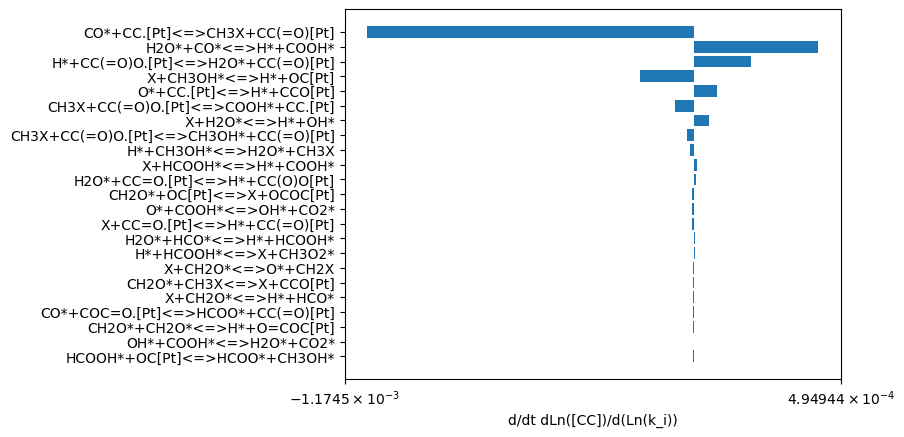

In [ ]:
plotrxntransitorysensitivities(ssys, "CC", 100)

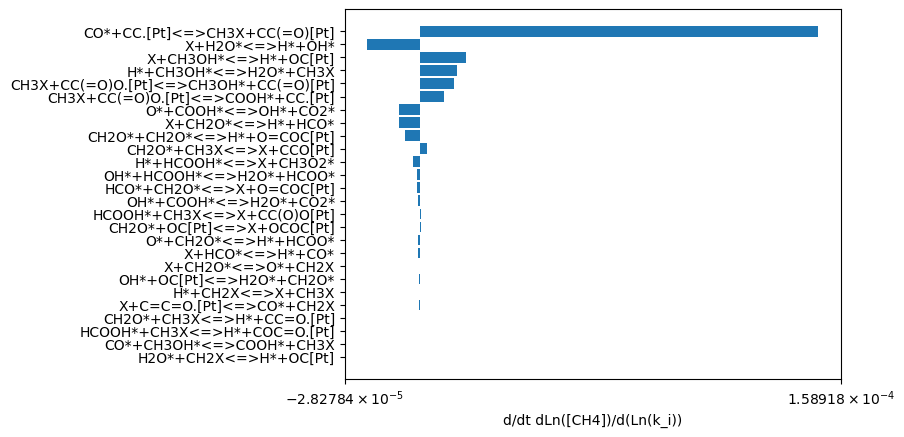

In [ ]:
plotrxntransitorysensitivities(ssys, "CH4", 100)

In [ ]:
rms_yaml = YAML.load_file(file_dir);

In [ ]:
rms_yaml_copy = deepcopy(rms_yaml)

Dict{Any, Any} with 4 entries:
  "Units"      => Dict{Any, Any}()
  "Interfaces" => Dict{Any, Any}[Dict()]
  "Reactions"  => Dict{Any, Any}[Dict("reactants"=>["X", "X", "H2"], "products"…
  "Phases"     => Dict{Any, Any}[Dict("name"=>"gas", "Species"=>Dict{Any, Any}[…

In [ ]:

# reac1 = "CH3OH*"
# reac2 = "O*"
# prod1 = "OH*"
# prod2 = "OC[Pt]"

# for (index, rxn) in enumerate(rms_yaml["Reactions"])
#     if reac1 in rxn["reactants"] && reac2 in rxn["reactants"]
#         if prod1 in rxn["products"] && prod2 in rxn["products"]
#             rms_yaml_copy["Reactions"] = deleteat!(rms_yaml["Reactions"], index)
#             print(rxn)
#         end
#     end
# end


In [ ]:
# YAML.write_file("modified_rms.rms", rms_yaml_copy)

### get rxns that have reactants and products of most sensitive reactions

In [ ]:
for rxn in ssys.reactions
    for reac in rxn.reactants
        if "CH3OH*" == reac.name
            println(rxn.index)
        end
    end
    for prod in rxn.products
        if "CO" == prod.name
            println(rxn.index)
        end
    end
end

19
24
35
36
46
47
49
59
91
93
95
97
103
111
119
122
124
142
143
163
219
220
221
222
240
263
334
376
411
445
446
482
483
484
500
512
513
521
546
563
574
6


## getting "follow" to work for CO2/CO 

In [ ]:
sim = ssys.sims[1]
t = 0.01
rop = rops(sim,t)
ropp = zeros(size(rop))
for i in eachindex(rop)
    if rop[i] > 0
        ropp[i] = rop[i]
    end
end
ropl = zeros(size(rop))
for i in eachindex(rop)
    if rop[i] < 0
        ropl[i] = abs(rop[i])
    end
end
rts = rates(sim,t)

9-element Vector{Float64}:
  4.692392573320831e-30
 -7.779038697241101e-23
  5.850877498922728e-26
  2.825021716905149e-24
  5.850877498922728e-26
  5.850877498922728e-26
 -8.144512356540212e-20
 -2.36851722885038e-25
 -2.8066121952044126e-30

In [ ]:
path = follow(ssys,135,9,ropp,ropl,rts,true;steptol=1e-2,branchtol=5e-2)
path.branchfracts

Float64[]

In [ ]:
fieldnames(typeof(path))

(:forward, :spcsinds, :rxninds, :spcind, :branchfracts, :branchfract, :branchind)

In [ ]:
obj = ssys.reactions[1]
# print(typeof(obj))
fieldnames(typeof(obj))


(:index, :reactants, :reactantinds, :products, :productinds, :kinetics, :electronchange, :radicalchange, :reversible, :pairs)

In [ ]:
obj.kinetics

Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 2890.0000000000005
  n: Float64 1.16
  Ea: Float64 343506.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()


In [ ]:
for rxn in ssys.reactions
    for reac in rxn.reactants
        if "CO" == reac.name
            println(rxn.index)
        end
    end
    for prod in rxn.products
        if "CO" == prod.name
            println(rxn.index)
        end
    end
end

1
2
4
9
6


In [ ]:

for index in 1:length(ssys.reactions)
    for reac in ssys.reactions[index].reactants
        if "CO" == reac.name
            print("!",index, "!") 
        end
        print(reac.name, " ")
    end
    print("<=> ")
    for prod in ssys.reactions[index].products
        if "CO" == prod.name
            print("!",index, "!")
        end
        print(prod.name, " ")
    end
    print("\n")
end

H2 !1!CO <=> CH2O 
H2O !2!CO <=> HCOOH 
H2 CO2 <=> HCOOH 
!4!CO CH3OH <=> HCOOCH3 
H2 CO2 <=> HCOOH 
H2 CO2 <=> HCOOH 
CO2 CH4 <=> HCOOCH3 
CO2 CH4 <=> CC(=O)O 
!9!CO CH4 <=> CC=O 
X OH* <=> O* H* 
X H2O* <=> H* OH* 
O* H2O* <=> OH* OH* 
O* CO* <=> X CO2* 
OH* CO* <=> H* CO2* 
HCOO* <=> COOH* 
X HCO* <=> H* CO* 
H* CO2* <=> X HCOO* 
X HCOO* <=> O* HCO* 
H* CO2* <=> X COOH* 
X COOH* <=> OH* CO* 
X HCOOH* <=> OH* HCO* 
X HCOOH* <=> H* HCOO* 
X HCOOH* <=> H* COOH* 
X CH2O* <=> H* HCO* 
H* CH2O* <=> X CH3O* 
OH* CH2O* <=> X CH3O2* 
H* HCOOH* <=> X CH3O2* 
X CH3OH* <=> H* CH3O* 
O* CH2O* <=> H* HCOO* 
H2O* CO* <=> H* COOH* 
OH* CH2O* <=> H* HCOOH* 
H2O* HCO* <=> H* HCOOH* 
O* CH3OH* <=> H* CH3O2* 
H2O* CH2O* <=> H* CH3O2* 
O* HCO* <=> OH* CO* 
O* HCOO* <=> OH* CO2* 
O* COOH* <=> OH* CO2* 
O* HCOOH* <=> OH* HCOO* 
O* HCOOH* <=> OH* HCOO* 
O* HCOOH* <=> OH* COOH* 
O* CH2O* <=> OH* HCO* 
O* CH3O* <=> OH* CH2O* 
O* CH3O2* <=> OH* HCOOH* 
O* CH3OH* <=> OH* CH3O* 
O* CH3OH* <=> OH* CH3O* 
H2O* CO

In [ ]:
fieldnames(typeof(ssys.reactions[1].reactants[1]))


(:name, :index, :inchi, :smiles, :adjlist, :thermo, :atomnums, :bondnum, :diffusion, :radius, :radicalelectrons, :molecularweight, :henrylawconstant, :liquidvolumetricmasstransfercoefficient)

In [ ]:
for spec in ssys.species
    println(spec.index, ":", spec.name, ": ", spec.smiles)
end

1:N2: N#N
2:Ne: [Ne]
3:H2: [H][H]
4:CO: [C-]#[O+]
5:CO2: O=C=O
6:H2O: O
7:CH2O: C=O
8:HCOOH: O=CO
9:CH3OH: CO
10:HCOOCH3: COC=O
11:CC(=O)O: CC(=O)O
12:CCO: CCO
13:CC=O: CC=O
14:CC: CC
15:CH4: C
1:X: [Pt]
2:H*: [Pt]
3:O*: O=[Pt]
4:OH*: O[Pt]
5:H2O*: O.[Pt]
6:CO*: O=C=[Pt]
7:CO2*: O=C=O.[Pt]
8:HCO*: O=C[Pt]
9:HCOO*: O=CO[Pt]
10:COOH*: O=C(O)[Pt]
11:HCOOH*: O=CO.[Pt]
12:CH2O*: C=O.[Pt]
13:CH3O*: CO[Pt]
14:CH3O2*: OCO[Pt]
15:CH3OH*: CO.[Pt]
16:OC[Pt]: OC[Pt]
17:O=COC[Pt]: O=COC[Pt]
18:OCOC[Pt]: OCOC[Pt]
19:COCO[Pt]: COCO[Pt]
20:COC=O.[Pt]: COC=O.[Pt]
21:CC(=O)[Pt]: CC(=O)[Pt]
22:C=C=O.[Pt]: C=C=O.[Pt]
23:C=C(O)O[Pt]: C=C(O)O[Pt]
24:C=CO[Pt]: C=CO[Pt]
25:CC(=O)O.[Pt]: CC(=O)O.[Pt]
26:CC(O)O[Pt]: CC(O)O[Pt]
27:CH3X: C[Pt]
28:CCO.[Pt]: CCO.[Pt]
29:CC(=O)O[Pt]: CC(=O)O[Pt]
30:CC=O.[Pt]: CC=O.[Pt]
31:CC(O)[Pt]: CC(O)[Pt]
32:CCO[Pt]: CCO[Pt]
33:CC.[Pt]: CC.[Pt]
34:CC[Pt]: CC[Pt]
35:CH2X: C=[Pt]
36:O=C([Pt])CO: O=C([Pt])CO
37:O=C=C[Pt]: O=C=C[Pt]
38:OCO.[Pt]: OCO.[Pt]


## get sensitive species

In [ ]:
function getthermotransitorysensitivities(bsol,name,t;dSdt=nothing,tau=nothing,tol=1e-3,N=0)
    if !(name in getfield.(bsol.species,:name))
        error("Species $name not in domain")
    end
    ind = findfirst(isequal(name),bsol.names)

    if dSdt === nothing
        if tau === nothing
            dSdt = transitorysensitivitiesfulltrapezoidal(bsol,t)[ind,1:length(bsol.names)]
        else
            dSdt = transitorysensitivitiesfulltrapezoidal(bsol,t,tau)[ind,1:length(bsol.names)]
        end
    else
        dSdt = dSdt[1:length(bsol.names)]
    end

    inds = reverse(sortperm(abs.(dSdt)))
    dSdtmax = maximum(abs.(dSdt))
    maxthresh = dSdtmax*tol

    if N == 0
        N = length(inds)
    elseif N > length(inds)
        N = length(inds)
    end
    
    inds = inds[1:N]
    mval = abs(dSdt[inds[1]])
    minval = mval*tol
    k = 1
    
    while k < length(inds) && abs(dSdt[inds[k]]) >= minval
        k += 1
    end
    
    inds = inds[1:k]
    
    sens = dSdt[inds]
    sens_spec = bsol.species[inds]

    return sens_spec, sens
end

getthermotransitorysensitivities (generic function with 1 method)

In [ ]:
sens_spec, sens_value = getthermotransitorysensitivities(ssys, "CC", 5)
for (spec, value) in zip(sens_spec, sens_value)
    println(spec, " ", value)
end

Species{NASA{EmptyThermoUncertainty}, EmptyDiffusivity, EmptyHenryLawConstant, EmptyLiquidVolumetricMassTransferCoefficient}
  name: String "OC[Pt]"
  index: Int64 16
  inchi: String ""
  smiles: String "OC[Pt]"
  adjlist: String "1 O u0 p2 c0 {2,S} {5,S}\n\n2 C u0 p0 c0 {1,S} {3,S} {4,S} {6,S}\n\n3 H u0 p0 c0 {2,S}\n\n4 H u0 p0 c0 {2,S}\n\n5 H u0 p0 c0 {1,S}\n\n6 X u0 p0 c0 {2,S}\n\n"
  thermo: NASA{EmptyThermoUncertainty}
  atomnums: Dict{String, Int64}
  bondnum: Int64 5
  diffusion: EmptyDiffusivity EmptyDiffusivity()
  radius: Float64 0.0
  radicalelectrons: Int64 0
  molecularweight: Float64 0.031033952604047954
  henrylawconstant: EmptyHenryLawConstant EmptyHenryLawConstant()
  liquidvolumetricmasstransfercoefficient: EmptyLiquidVolumetricMassTransferCoefficient EmptyLiquidVolumetricMassTransferCoefficient()
 844.323226566422
Species{NASA{EmptyThermoUncertainty}, EmptyDiffusivity, EmptyHenryLawConstant, EmptyLiquidVolumetricMassTransferCoefficient}
  name: String "OCOC[Pt]"
  in

In [ ]:
yaml_sens_spec_dir = "/work/westgroup/ChrisB/_01_MeOH_repos/model_compare/sens_species.yaml"
YAML.write_file(yaml_sens_spec_dir, sort(collect(sens_spec_dict), by=x->x[2][1]))

LoadError: UndefVarError: sens_spec_dict not defined

In [ ]:
sens_times = [1e-2, 3e-2, 100]
sens_spec_dict = Dict()
sens_spec_adj_dict = Dict()

for time in sens_times 
    sens_spec, sens_value = getthermotransitorysensitivities(ssys, "CH3OH", time)
    counter = 0
    for (spec, sens) in zip(sens_spec, sens_value)
        if spec.name in keys(sens_spec_dict)
            old_sens = sens_spec_dict[spec.name]
            sens_spec_dict[spec.name] = old_sens*sens
            sens_spec_adj_dict[spec.name] = spec.adjlist
        else
            sens_spec_dict[spec.name] = sens
            sens_spec_adj_dict[spec.name] = spec.adjlist
        end
        counter +=1
    end
end

for time in sens_times 
    sens_spec, sens_value = getthermotransitorysensitivities(ssys, "H2O", time)
    counter = 0
    for (spec, sens) in zip(sens_spec, sens_value)
        if spec.name in keys(sens_spec_dict)
            old_sens = sens_spec_dict[spec.name]
            sens_spec_dict[spec.name] = old_sens*sens
            sens_spec_adj_dict[spec.name] = spec.adjlist
        else
            sens_spec_dict[spec.name] = sens
            sens_spec_adj_dict[spec.name] = spec.adjlist
        end
        counter +=1
    end
end


sens_spec_dict

LoadError: UndefVarError: OrderedDict not defined

In [ ]:
yaml_sens_spec_dir = "./sens_species.yaml"
YAML.write_file(yaml_sens_spec_dir, sort(collect(sens_spec_dict), by=x->abs(x[2][1]), rev=true))

In [ ]:
sort_spec_sens_dict = sort(collect(sens_spec_dict), by=x->abs(x[2][1]), rev=true)
sens_spec_adj_dict_out = Dict()

for (spec, sens) in sort_spec_sens_dict
    sens_spec_adj_dict_out[spec] = [sens_spec_dict[spec], sens_spec_adj_dict[spec]]
end 
yaml_sens_spec_adj_dir = "./sens_spec_adj.yaml"
YAML.write_file(yaml_sens_spec_adj_dir, sort(collect(sens_spec_adj_dict_out), by=x->abs(x[2][1]), rev=true))

In [ ]:
for (spec, adj) in sens_spec_adj_dict_out
    print

Dict{Any, Any} with 18 entries:
  "CC(=O)[Pt]"   => "1 O u0 p2 c0 {3,D}\n\n2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}…
  "C=CO[Pt]"     => "1 O u0 p2 c0 {2,S} {7,S}\n\n2 C u0 p0 c0 {1,S} {3,D} {4,S}…
  "CC(=O)O.[Pt]" => "1 O u0 p2 c0 {4,S} {8,S}\n\n2 O u0 p2 c0 {4,D}\n\n3 C u0 p…
  "O=COC[Pt]"    => "1 O u0 p2 c0 {3,S} {4,S}\n\n2 O u0 p2 c0 {4,D}\n\n3 C u0 p…
  "COC=O.[Pt]"   => "1 O u0 p2 c0 {3,S} {4,S}\n\n2 O u0 p2 c0 {4,D}\n\n3 C u0 p…
  "O=C([Pt])CO"  => "1 O u0 p2 c0 {3,S} {7,S}\n\n2 O u0 p2 c0 {4,D}\n\n3 C u0 p…
  "OCOC[Pt]"     => "1  O u0 p2 c0 {3,S} {4,S}\n\n2  O u0 p2 c0 {3,S} {9,S}\n\n…
  "OC[Pt]"       => "1 O u0 p2 c0 {2,S} {5,S}\n\n2 C u0 p0 c0 {1,S} {3,S} {4,S}…
  "CC=O.[Pt]"    => "1 O u0 p2 c0 {3,D}\n\n2 C u0 p0 c0 {3,S} {4,S} {5,S} {6,S}…
  "CH3O2*"       => "1 O u0 p2 c0 {3,S} {6,S}\n\n2 O u0 p2 c0 {3,S} {7,S}\n\n3 …
  "COCO[Pt]"     => "1  O u0 p2 c0 {3,S} {4,S}\n\n2  O u0 p2 c0 {3,S} {10,S}\n\…
  "CC(=O)O[Pt]"  => "1 O u0 p2 c0 {4,S} {8,S}\n\n2 O u0 p2 c0 {4,D}\n\n3 C u0